# CellMap for hippocampus cell data

The tutorial for hippocampus cell data ([La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6)).


[RECODE](https://github.com/yusuke-imoto-lab/RECODE) is used for the noise reduction.

## Regular procedure

In [1]:
import cellmap
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy

The dataset is installed using the [scvelo](https://scvelo.readthedocs.io/en/stable/) package. 

In [2]:
import scvelo as scv
adata = scv.datasets.dentategyrus_lamanno()
adata

AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Noise reduction by [RECODE](https://github.com/yusuke-imoto-lab/RECODE).

In [ ]:
import screcode
recode = screcode.RECODE()
adata = recode.fit_transform(adata)
adata.obsm['RECODE_log'] = scanpy.pp.log1p(adata.obsm['RECODE'])
recode.report()

Compute velocity and show the stream on UMAP. 

In [4]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata,mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: spliced, unspliced.
computing neighbors


2023-03-31 17:39:29.049456: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 17:39:29.055666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 17:39:29.129204: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 17:39:29.133039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 17:39:31.002326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

    finished (0:01:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:46) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:01:31) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:06:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:10) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


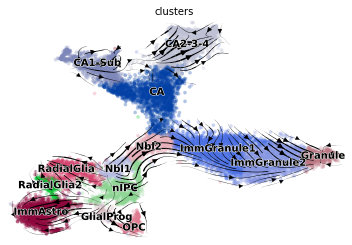

In [5]:
scv.pl.velocity_embedding_stream(adata)

In [6]:
%%time
import cellmap

cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne', alpha=0.1)

[0. 0. 0. ... 0. 0. 0.]
{'Contribution_ratio': {'Potential': '74.70%', 'Rotation': '25.30%'}}
CPU times: user 42min 59s, sys: 4min 51s, total: 47min 51s
Wall time: 14min 35s


In [ ]:
cellmap.view(adata, basis='X_tsne', show_graph = True, cluster_key='clusters')

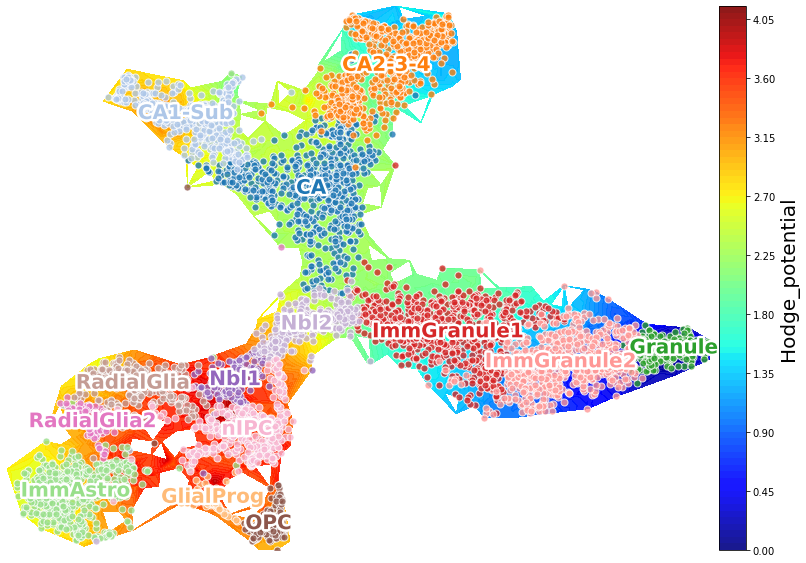

In [8]:
cellmap.view_cluster(adata, basis='X_tsne', show_graph=True, cluster_key='clusters', s=50)

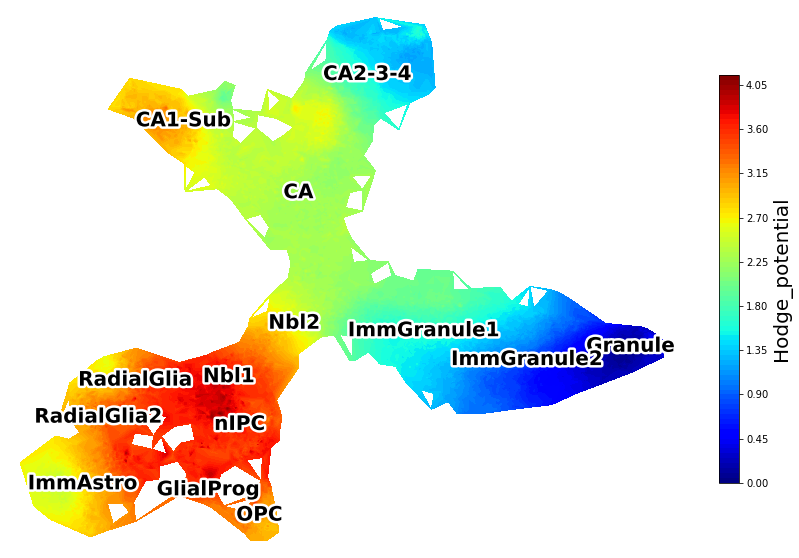

In [9]:
cellmap.view_surface(adata, basis='X_tsne', cluster_key ='clusters')

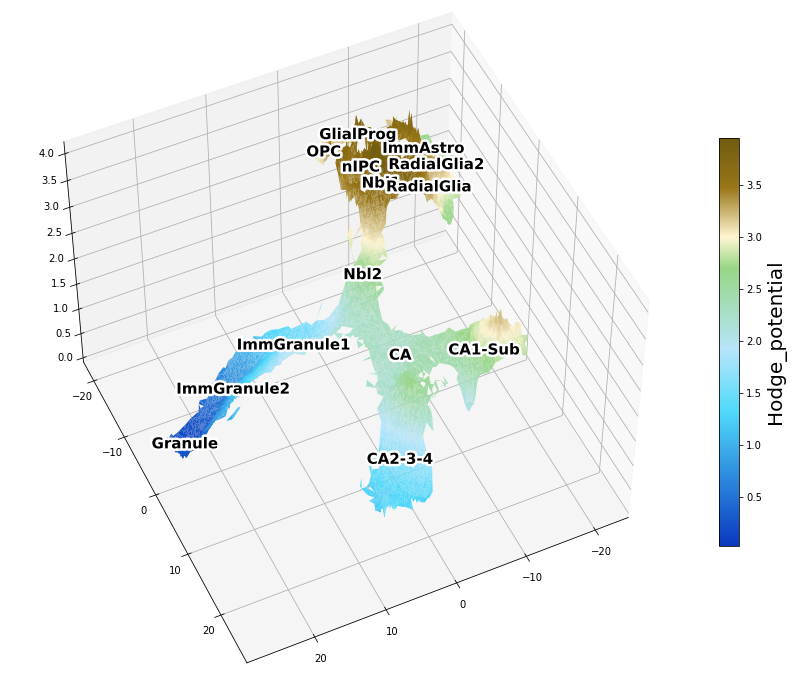

In [10]:
cellmap.view_surface_3D(adata, basis='X_tsne', cluster_key ='clusters', elev=50, azim=65)

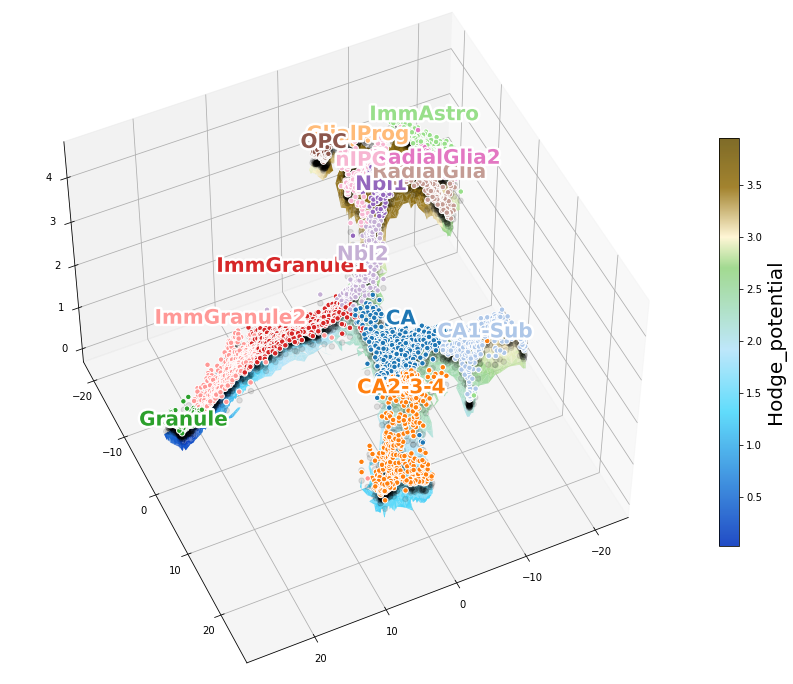

In [11]:
cellmap.view_surface_3D_cluster(adata, basis='X_tsne', cluster_key ='clusters',elev=50,azim=65,s=30);

### Write expression and potential data as CSV file for **[CellMap viewer](https://github.com/yusuke-imoto-lab/CellMapViewer)**. 

In [12]:
cellmap.write(adata, basis='X_tsne', filename='CellMap_tutorial_hippocampus',genes=['Aqp4','Aldoc','Cdk1','Mki67','Eomes','Neurod2'],expression_key='RECODE_log')

succeeded in writing CellMapp data as "CellMap_tutorial_hippocampus.csv"
you can visualize the CDV file by CellMapp viewer https://yusuke-imoto-lab.github.io/CellMapViewer/CellMapViewer/viewer.html


,X,Y,Potential,Annotation,Aqp4,Aldoc,Cdk1,Mki67,Eomes,Neurod2,HVG_Nts,HVG_Gfap,HVG_Cenpa,HVG_Calb1,HVG_Fxyd7,HVG_Cpne4,HVG_2810417H13Rik,HVG_Aqp4,HVG_Igfbp5,HVG_Xist
CellID,,,,,,,,,,,,,,,,,,,,
10X83_2:AAACGGGGTCTCTTTAx,18.931086,-1.862429,0.870563,ImmGranule2,0.0,0.0,0.0,0.0,0.000000,1.098612,0.0,0.0,0.000000,2.397895,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10X83_2:AACCATGGTTCAACCAx,18.419891,-1.282895,0.960821,ImmGranule2,0.0,0.0,0.0,0.0,0.000000,0.693147,0.0,0.0,0.693147,0.693147,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10X83_2:AACACGTTCTGAAAGAx,2.369887,16.868419,2.188863,CA2-3-4,0.0,0.0,0.0,0.0,0.000000,1.609438,0.0,0.0,0.000000,0.000000,1.609438,0.693147,0.000000,0.0,0.0,2.397895
10X83_2:AAAGATGCATTGAGCTx,-5.351040,10.676485,2.409693,CA,0.0,0.0,0.0,0.0,0.000000,1.098612,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10X83_2:AACCATGTCTACTTACx,-6.189126,11.754900,2.419396,CA1-Sub,0.0,0.0,0.0,0.0,0.000000,2.079442,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X84_3:TTTCCTCCACCATCCTx,10.812611,-2.487668,1.522177,ImmGranule1,0.0,0.0,0.0,0.0,0.000000,1.386294,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10X84_3:TTTGTCACATGAAGTAx,8.246204,23.482788,1.456176,CA2-3-4,0.0,0.0,0.0,0.0,0.000000,1.945910,0.0,0.0,0.693147,0.000000,1.945910,1.791759,0.000000,0.0,0.0,0.000000
10X84_3:TTTCCTCCACGGTAAGx,-3.441272,-4.917364,3.236499,nIPC,0.0,0.0,0.0,0.0,1.791759,0.000000,0.0,0.0,1.098612,0.000000,0.693147,0.693147,0.693147,0.0,0.0,0.000000


## Changing parameter $\alpha$

The parameter $\alpha$ adjust the rate of original/reduced dimensional information of gene expression and velocity. 

$\alpha=0$ uses only two-dimensional inormation; in contrast, $\alpha=1$ uses the original (non-dimensionaly reduction) information. 

In [13]:
alpha_set = [0,0.5,1]
for alpha in alpha_set:
    cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne',potential_key='Hodge_potential_%0.1f' % alpha,alpha=alpha)
adata

[ 0.00000000e+00 -4.95635279e-19  3.46944695e-19 ...  0.00000000e+00
  8.67361738e-19  0.00000000e+00]
{'Contribution_ratio': {'Potential': '54.42%', 'Rotation': '45.58%'}}
[0. 0. 0. ... 0. 0. 0.]
{'Contribution_ratio': {'Potential': '86.04%', 'Rotation': '13.96%'}}


KeyboardInterrupt: 

In [ ]:
for alpha in alpha_set:
    cellmap.view(adata, basis='X_tsne', show_graph = True, potential_key='Hodge_potential_%0.1f' % alpha,cluster_key='clusters',title='alpha=%0.1f' % alpha,s=1)

In [ ]:
for alpha in alpha_set:
    cellmap.view_surface_3D(adata, basis='X_tsne', cluster_key ='clusters',potential_key='Hodge_potential_%0.1f' % alpha,elev=50,azim=65,title='alpha=%0.1f' % alpha)